In [133]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- 1. Helper Functions ---

def to_float64(img):
    """Converts uint8 image (0-255) to float64 [0, 1]."""
    if img.dtype == np.uint8:
        return img.astype(np.float64) / 255.0
    return img

def to_uint8(img):
    """Converts float image [0, 1] back to uint8 (0-255)."""
    img_clamped = np.clip(img, 0, 1)
    return (img_clamped * 255).astype(np.uint8)

def load_and_resize(path, max_dim=800):
    """
    Loads image, handles missing files, and resizes if too large.
    Ensures 'clean environment' execution by checking local and subfolder paths.
    """
    if not os.path.exists(path):
        # Fallback for Colab: check in 'images' folder if it exists
        if os.path.exists(os.path.join('images', path)):
            path = os.path.join('images', path)
        else:
            print(f"WARNING: File {path} not found. Please upload it to Colab.")
            return None

    img = cv2.imread(path)
    if img is None:
        print(f"ERROR: Could not read {path}.")
        return None

    h, w = img.shape[:2]
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        img = cv2.resize(img, (int(w * scale), int(h * scale)))
    return img

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
# --- Part A: Convolution & Filters ---

def convolve2d_manual(image, kernel, padding='reflect'):
    """
    Manual 2D convolution using NumPy vectorization.
    Strictly forbids cv2.filter2D.
    """
    k_h, k_w = kernel.shape
    h, w = image.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    # 1. Padding
    if padding == 'zero':
        padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    elif padding == 'replicate':
        padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    else: # reflect
        padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    output = np.zeros_like(image)

    # 2. Convolution (Flip Kernel)
    kernel_flipped = np.flip(np.flip(kernel, 0), 1)

    # 3. Vectorized implementation
    for i in range(k_h):
        for j in range(k_w):
            region = padded_img[i:i+h, j:j+w]
            output += region * kernel_flipped[i, j]

    return output

def create_gaussian_kernel(ksize, sigma):
    """Generates a 2D Gaussian kernel."""
    ax = np.linspace(-(ksize - 1) / 2., (ksize - 1) / 2., ksize)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def create_mean_kernel(ksize):
    return np.ones((ksize, ksize)) / (ksize * ksize)

# --- Noise Generators ---
def add_noise(image, noise_type="gaussian", severity=0.05):
    """Adds simulated noise to the image."""
    noisy = image.copy()
    if noise_type == "gaussian":
        noise = np.random.normal(0, severity, image.shape)
        noisy += noise
    elif noise_type == "sp": # Salt & Pepper
        num_salt = np.ceil(severity * image.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy[tuple(coords)] = 1

        num_pepper = np.ceil(severity * image.size * 0.5)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy[tuple(coords)] = 0
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)

    return np.clip(noisy, 0, 1)

def filter_color_image(img_color, kernel, mode='intensity'):
    """
    Applies the manual convolution to color images.
    """
    if mode == 'intensity':
        # Convert to Float32 for OpenCV compatibility
        img_32 = img_color.astype(np.float32)
        hsv = cv2.cvtColor(img_32, cv2.COLOR_BGR2HSV)

        h, s, v = cv2.split(hsv)
        v_float = to_float64(v)

        # manual func
        v_filtered = convolve2d_manual(v_float, kernel)

        v_res = v_filtered.astype(np.float32)
        merged = cv2.merge([h, s, v_res])
        return cv2.cvtColor(merged, cv2.COLOR_HSV2BGR)

    elif mode == 'per_channel':
        b, g, r = cv2.split(img_color)

        # manual func
        b_res = convolve2d_manual(to_float64(b), kernel)
        g_res = convolve2d_manual(to_float64(g), kernel)
        r_res = convolve2d_manual(to_float64(r), kernel)

        return cv2.merge([b_res, g_res, r_res])

    elif mode == 'per_channel':
        b, g, r = cv2.split(img_float)

        # Convolve each channel (inputs are already float 0-1)
        b_res = convolve2d_manual(b, kernel)
        g_res = convolve2d_manual(g, kernel)
        r_res = convolve2d_manual(r, kernel)

        res_float = cv2.merge([b_res, g_res, r_res])
        return to_uint8(res_float)

    elif mode == 'per_channel':
        b, g, r = cv2.split(img_float)

        # Convolve each channel (inputs are already float 0-1)
        b_res = convolve2d_manual(b, kernel)
        g_res = convolve2d_manual(g, kernel)
        r_res = convolve2d_manual(r, kernel)

        res_float = cv2.merge([b_res, g_res, r_res])
        return to_uint8(res_float)

# --- EXPERIMENT SCRIPT PART A ---
def run_part_a_experiments(image_path):
    print(f"\n--- Running Part A Experiments on {image_path} ---")
    img_bgr = load_and_resize(image_path, max_dim=600)
    if img_bgr is None: return

    # Use FLOAT COLOR image for noise processing
    img_float = to_float64(img_bgr)

    # 1. Noise Visual Comparison (COLOR)
    n_gauss = add_noise(img_float, "gaussian", 0.1)
    n_sp = add_noise(img_float, "sp", 0.05)
    n_poisson = add_noise(img_float, "poisson")

    plt.figure(figsize=(15, 5))
    plt.subplot(141), plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)), plt.title("Original (Color)")
    plt.subplot(142), plt.imshow(cv2.cvtColor(to_uint8(n_gauss), cv2.COLOR_BGR2RGB)), plt.title("Gaussian Noise")
    plt.subplot(143), plt.imshow(cv2.cvtColor(to_uint8(n_sp), cv2.COLOR_BGR2RGB)), plt.title("S&P Noise")
    plt.subplot(144), plt.imshow(cv2.cvtColor(to_uint8(n_poisson), cv2.COLOR_BGR2RGB)), plt.title("Poisson Noise")
    plt.show()

    # 2. Smoothing vs Noise Type (S&P Focus - COLOR)
    k_gauss = create_gaussian_kernel(ksize=5, sigma=1.5)
    k_mean = create_mean_kernel(ksize=5)

    # Use filter_color_image to maintain color
    denoised_gauss = filter_color_image(n_sp, k_gauss, mode='per_channel')
    denoised_mean = filter_color_image(n_sp, k_mean, mode='per_channel')

    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(cv2.cvtColor(to_uint8(n_sp), cv2.COLOR_BGR2RGB)), plt.title("Noisy (S&P)")
    plt.subplot(132), plt.imshow(cv2.cvtColor(to_uint8(denoised_mean), cv2.COLOR_BGR2RGB)), plt.title("Mean Filter (5x5)")
    plt.subplot(133), plt.imshow(cv2.cvtColor(to_uint8(denoised_gauss), cv2.COLOR_BGR2RGB)), plt.title("Gaussian Filter (s=1.5)")
    plt.suptitle("Comparison: Which filter handles outliers better?")
    plt.show()

    # 3. Color Strategy Comparison
    img_color_noisy = add_noise(img_float, "gaussian", 0.05)
    res_per_channel = filter_color_image(img_color_noisy, k_gauss, mode='per_channel')
    res_intensity = filter_color_image(img_color_noisy, k_gauss, mode='intensity')

    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(cv2.cvtColor(to_uint8(res_per_channel), cv2.COLOR_BGR2RGB)), plt.title("Per RGB Channel")
    plt.subplot(122), plt.imshow(cv2.cvtColor(to_uint8(res_intensity), cv2.COLOR_BGR2RGB)), plt.title("Intensity (V) Only")
    plt.suptitle("Color Strategy")
    plt.show()

In [136]:
# --- Part B: Canny Edge Detection ---

def get_sobel_gradients(img):
    """Calculates gradients Gx, Gy, Magnitude and Direction."""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)
    Ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float64)

    Ix = convolve2d_manual(img, Kx)
    Iy = convolve2d_manual(img, Ky)

    magnitude = np.sqrt(Ix**2 + Iy**2)
    direction = np.arctan2(Iy, Ix)
    return magnitude, direction

def non_max_suppression(magnitude, direction):
    """Thins edges by keeping only local maxima along gradient direction."""
    h, w = magnitude.shape
    Z = np.zeros((h, w), dtype=np.float64)

    # Convert radians to degrees and shift to [0, 180]
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, h-1):
        for j in range(1, w-1):
            q = 255
            r = 255

            # 0 degrees (Horizontal gradient -> Vertical Edge)
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = magnitude[i, j+1]
                r = magnitude[i, j-1]
            # 45 degrees
            elif (22.5 <= angle[i,j] < 67.5):
                q = magnitude[i+1, j-1]
                r = magnitude[i-1, j+1]
            # 90 degrees (Vertical gradient -> Horizontal Edge)
            elif (67.5 <= angle[i,j] < 112.5):
                q = magnitude[i+1, j]
                r = magnitude[i-1, j]
            # 135 degrees
            elif (112.5 <= angle[i,j] < 157.5):
                q = magnitude[i-1, j-1]
                r = magnitude[i+1, j+1]

            if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                Z[i,j] = magnitude[i,j]
            else:
                Z[i,j] = 0
    return Z

def hysteresis_thresholding(img, lowRatio=0.05, highRatio=0.15):
    """Links weak edges to strong edges using stack-based iteration."""
    highThreshold = img.max() * highRatio
    lowThreshold = highThreshold * lowRatio

    h, w = img.shape
    res = np.zeros((h,w), dtype=np.int32)

    weak, strong = 25, 255

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # Stack-based tracking
    stack = list(zip(strong_i, strong_j))

    while stack:
        i, j = stack.pop()
        for di in [-1,0,1]:
            for dj in [-1,0,1]:
                if di==0 and dj==0: continue
                ni, nj = i+di, j+dj
                if 0 <= ni < h and 0 <= nj < w:
                    if res[ni, nj] == weak:
                        res[ni, nj] = strong
                        stack.append((ni, nj))

    res[res != strong] = 0
    return res

def my_canny(image, sigma=1.0):
    """Full Canny Pipeline wrapper."""
    kernel = create_gaussian_kernel(5, sigma)
    blurred = convolve2d_manual(image, kernel)
    mag, angle = get_sobel_gradients(blurred)
    thinned = non_max_suppression(mag, angle)
    final = hysteresis_thresholding(thinned)
    return final.astype(np.uint8)

# --- EXPERIMENT SCRIPT PART B ---
def run_part_b_experiments(image_path):
    print(f"\n--- Running Part B Experiments on {image_path} ---")
    img_bgr = load_and_resize(image_path)
    if img_bgr is None: return

    # Convert to Grayscale & Float for processing
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_float = to_float64(img_gray)

    # 1. Simple Thresholding vs Gradient Magnitude
    k_gauss = create_gaussian_kernel(5, 1.4)
    blurred = convolve2d_manual(img_float, k_gauss)
    mag, _ = get_sobel_gradients(blurred)

    simple_thresh_val = 0.2 * mag.max()
    simple_edges = np.zeros_like(mag)
    simple_edges[mag > simple_thresh_val] = 1

    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(mag, cmap='gray'), plt.title("Gradient Magnitude")
    plt.subplot(122), plt.imshow(simple_edges, cmap='gray'), plt.title(f"Simple Threshold > {simple_thresh_val:.2f}")
    plt.show()

    # 2. Full Canny Comparison (Manual vs OpenCV)
    my_canny_res = my_canny(img_float, sigma=1.4)
    cv_canny_res = cv2.Canny(img_gray, int(255*0.05), int(255*0.15))

    plt.figure(figsize=(15, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)), plt.title("Original (Color)")
    plt.subplot(132), plt.imshow(my_canny_res, cmap='gray'), plt.title("My Canny")
    plt.subplot(133), plt.imshow(cv_canny_res, cmap='gray'), plt.title("OpenCV Canny")
    plt.show()

In [137]:
# --- Part C: Corner Detection ---

def detect_moravec_corners(img, window_size=3, threshold_val=0.01):
    """Moravec Detector: Min SSD in 4 directions."""
    h, w = img.shape
    offset = window_size // 2
    # Increase margin by 1 to handle the (du, dv) shifts without going out of bounds
    margin = offset + 1

    scores = np.zeros_like(img)

    shifts = [(1, 0), (0, 1), (1, 1), (-1, 1)]

    for y in range(margin, h - margin):
        for x in range(margin, w - margin):
            patch = img[y-offset:y+offset+1, x-offset:x+offset+1]
            ssds = []
            for du, dv in shifts:
                # Calculate shifted window coordinates
                sy, sx = y + dv, x + du
                shifted = img[sy-offset:sy+offset+1, sx-offset:sx+offset+1]

                diff = patch - shifted
                ssds.append(np.sum(diff ** 2))
            scores[y, x] = min(ssds)

    corners = np.zeros_like(scores)
    thresh = scores.max() * threshold_val

    # NMS Loop
    for y in range(margin, h - margin):
        for x in range(margin, w - margin):
            if scores[y,x] > thresh:
                if scores[y,x] == np.max(scores[y-1:y+2, x-1:x+2]): # Local Max
                    corners[y,x] = 1
    return corners, scores

def detect_harris_corners(img, k=0.05, window_size=3, threshold=0.01):
    """Harris Detector: R = det(M) - k(traceM)^2."""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    Ix = convolve2d_manual(img, Kx)
    Iy = convolve2d_manual(img, Ky)

    Ixx, Iyy, Ixy = Ix**2, Iy**2, Ix*Iy

    gauss_window = create_gaussian_kernel(window_size, 1.0)
    Sxx = convolve2d_manual(Ixx, gauss_window)
    Syy = convolve2d_manual(Iyy, gauss_window)
    Sxy = convolve2d_manual(Ixy, gauss_window)

    detM = (Sxx * Syy) - (Sxy**2)
    traceM = Sxx + Syy
    R = detM - k * (traceM**2)

    corners = np.zeros_like(R)
    R_max = R.max()
    for i in range(1, R.shape[0]-1):
        for j in range(1, R.shape[1]-1):
            if R[i,j] > threshold * R_max:
                if R[i,j] == np.max(R[i-1:i+2, j-1:j+2]):
                    corners[i,j] = 1
    return corners, R

def gaussian_pyramid(img, levels=3):
    """Creates Gaussian Pyramid."""
    pyramid = [img]
    temp = img
    kernel = create_gaussian_kernel(5, 1.0)
    for i in range(levels - 1):
        blurred = convolve2d_manual(temp, kernel)
        downsampled = blurred[::2, ::2]
        pyramid.append(downsampled)
        temp = downsampled
    return pyramid

# --- EXPERIMENT SCRIPT PART C ---
def run_part_c_experiments(image_paths):
    print("\n--- Running Part C Experiments ---")
    if len(image_paths) < 3:
        print("Need at least 3 images for Part C experiments.")

    # 1. Moravec
    for i, fname in enumerate(image_paths):
        img = load_and_resize(fname, max_dim=600)
        if img is None: continue
        gray = to_float64(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        corners, _ = detect_moravec_corners(gray, window_size=3)

        vis = img.copy() # Keeps the color channels
        y, x = np.where(corners > 0)
        for (xi, yi) in zip(x, y): cv2.circle(vis, (xi, yi), 3, (0, 0, 255), -1)

        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Moravec Corners - Image {i+1} ({fname})")
        plt.show()

    # 2. Comparison (Harris vs Moravec)
    # We use the first image (usually the book or building) for the detailed comparison
    test_img = load_and_resize(image_paths[0], max_dim=600)
    if test_img is not None:
        gray = to_float64(cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY))

        m_win3, _ = detect_moravec_corners(gray, window_size=3)
        h_win3, _ = detect_harris_corners(gray, window_size=3)

        def draw_c(img, c_map, col):
            v = img.copy(); y, x = np.where(c_map > 0)
            for (xi, yi) in zip(x, y): cv2.circle(v, (xi, yi), 3, col, -1)
            return v

        plt.figure(figsize=(10, 5))
        plt.subplot(121), plt.imshow(cv2.cvtColor(draw_c(test_img, m_win3, (255,0,0)), cv2.COLOR_BGR2RGB)), plt.title("Moravec")
        plt.subplot(122), plt.imshow(cv2.cvtColor(draw_c(test_img, h_win3, (0,255,0)), cv2.COLOR_BGR2RGB)), plt.title("Harris")
        plt.show()

    # 3. Pyramid
    if test_img is not None:
        pyramid = gaussian_pyramid(gray, levels=3)
        plt.figure(figsize=(15, 5))
        for i, level_img in enumerate(pyramid):
            c_level, _ = detect_harris_corners(level_img, threshold=0.01)

            vis_level = cv2.cvtColor(to_uint8(level_img), cv2.COLOR_GRAY2BGR)
            y, x = np.where(c_level > 0)
            for (xi, yi) in zip(x, y): cv2.circle(vis_level, (xi, yi), 2, (0,0,255), -1)

            plt.subplot(1, 3, i+1)
            plt.imshow(cv2.cvtColor(vis_level, cv2.COLOR_BGR2RGB))
            plt.title(f"Level {i}")
        plt.show()

In [138]:
# --- Part D: Rectification Tool (EXAM COMPLIANT: HARRIS + HEURISTICS + MANUAL BLUR) ---

def get_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def find_corners_using_harris_heuristic(img_bgr):
    """
    EXAM REQUIREMENT:
    1. Uses Harris Detector (from Part C).
    2. Uses 'Simple Geometric Criteria' to select 4 corners.
    3. Uses MANUAL BLUR (Part A) to suppress text.
    """
    h, w = img_bgr.shape[:2]
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # --- MANUAL BLUR IMPLEMENTATION ---
    # 1. Convert to float64 (Required for our manual functions)
    img_float = to_float64(img_gray)

    # 2. Create the Gaussian Kernel Manually
    # We use size 15 and sigma 2.0 to blur out the text details
    kernel = create_gaussian_kernel(ksize=15, sigma=2.0)

    # 3. Apply Manual Convolution
    blurred_float = convolve2d_manual(img_float, kernel, padding='reflect')

    # --- RUN HARRIS ---
    # blurred_float is already [0,1], so we pass it directly
    corners_map, _ = detect_harris_corners(blurred_float, threshold=0.001)

    # Get all coordinate points where Harris found a corner
    y_coords, x_coords = np.where(corners_map > 0)
    all_corners = list(zip(x_coords, y_coords))

    if not all_corners:
        print("Warning: No Harris corners found. Lower the threshold.")
        return [(0,0), (w,0), (w,h), (0,h)]

    # --- GEOMETRIC HEURISTIC (Select 4 corners) ---
    mid_x, mid_y = w // 2, h // 2

    best_tl = (0, 0); min_dist_tl = float('inf')
    best_tr = (w, 0); min_dist_tr = float('inf')
    best_bl = (0, h); min_dist_bl = float('inf')
    best_br = (w, h); min_dist_br = float('inf')

    for (px, py) in all_corners:
        # Top-Left Quadrant
        if px < mid_x and py < mid_y:
            d = get_distance((px, py), (0, 0))
            if d < min_dist_tl: min_dist_tl = d; best_tl = (px, py)

        # Top-Right Quadrant
        elif px >= mid_x and py < mid_y:
            d = get_distance((px, py), (w, 0))
            if d < min_dist_tr: min_dist_tr = d; best_tr = (px, py)

        # Bottom-Left Quadrant
        elif px < mid_x and py >= mid_y:
            d = get_distance((px, py), (0, h))
            if d < min_dist_bl: min_dist_bl = d; best_bl = (px, py)

        # Bottom-Right Quadrant
        elif px >= mid_x and py >= mid_y:
            d = get_distance((px, py), (w, h))
            if d < min_dist_br: min_dist_br = d; best_br = (px, py)

    return [best_tl, best_tr, best_br, best_bl]

def rectify_document(img_color, rough_corners):
    """Standard Homography Rectification."""
    refined_corners = np.array(rough_corners, dtype="float32")
    (tl, tr, br, bl) = refined_corners

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(refined_corners, dst)
    warped = cv2.warpPerspective(img_color, M, (maxWidth, maxHeight))

    return warped, refined_corners

# --- EXPERIMENT SCRIPT PART D ---
def run_part_d_experiments(image_path, rough_corners=None):
    print(f"\n--- Running Part D Rectification on {image_path} ---")
    img_bgr = load_and_resize(image_path, max_dim=800)
    if img_bgr is None: return

    if rough_corners is None:
        print("Auto-Selecting corners using Harris + Geometric Heuristics (MANUAL BLUR)...")
        rough_corners = find_corners_using_harris_heuristic(img_bgr)
        print(f"Selected Harris Corners: {rough_corners}")

    warped, refined_pts = rectify_document(img_bgr, rough_corners)

    vis = img_bgr.copy()
    for i, pt in enumerate(refined_pts):
        cv2.circle(vis, (int(pt[0]), int(pt[1])), 8, (0, 0, 255), -1)
        next_pt = refined_pts[(i+1)%4]
        cv2.line(vis, (int(pt[0]), int(pt[1])), (int(next_pt[0]), int(next_pt[1])), (0, 255, 0), 2)

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)), plt.title("Harris Corners Selected")
    plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)), plt.title("Rectified Result")
    plt.show()


=== STARTING COMPUTER VISION PIPELINE ===

--- Running Part A Experiments on bricktexture.jpg ---


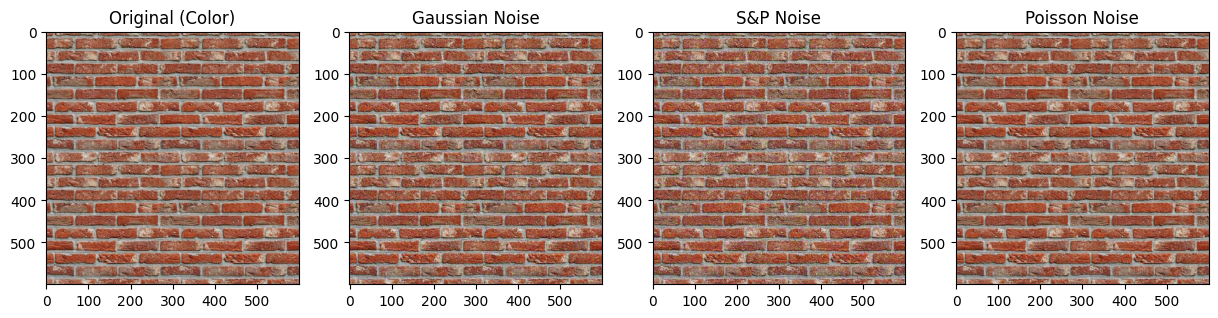

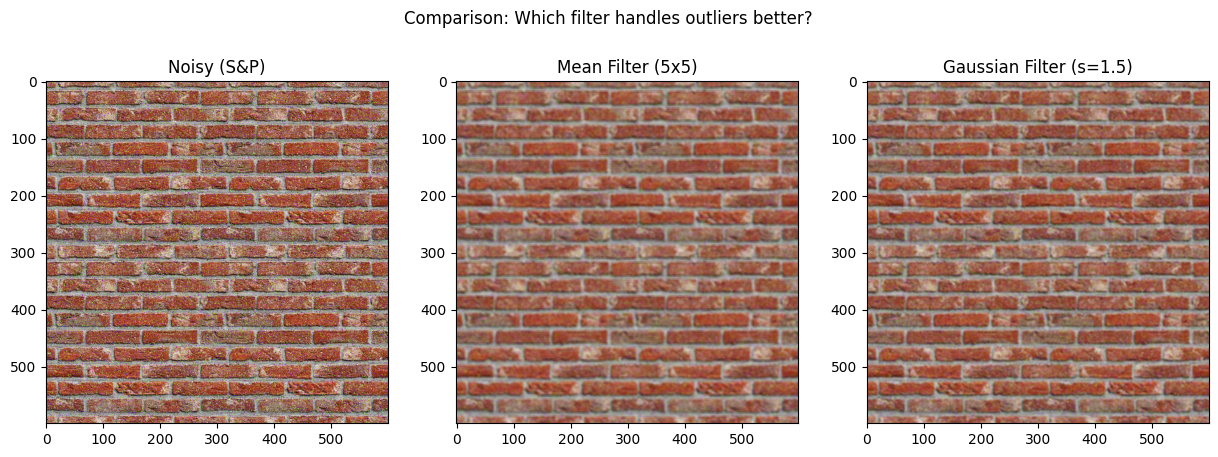

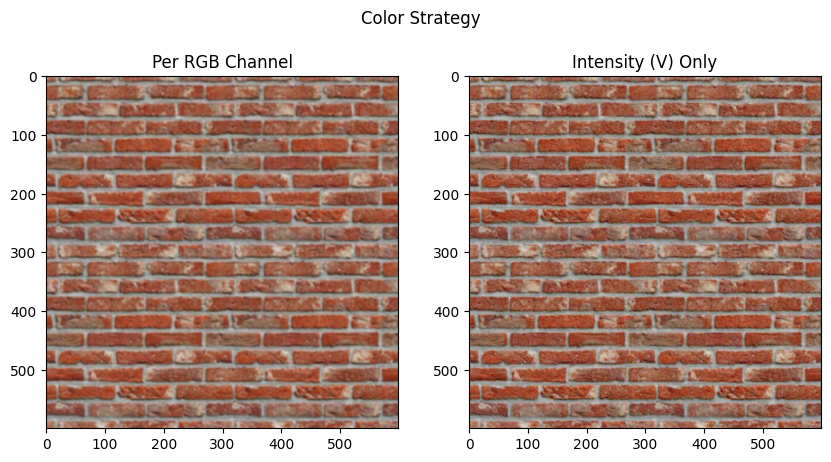


--- Running Part B Experiments on building.jpg ---


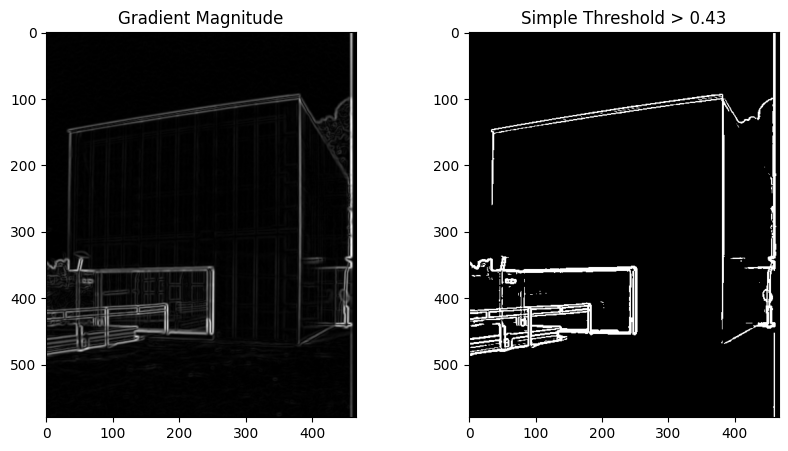

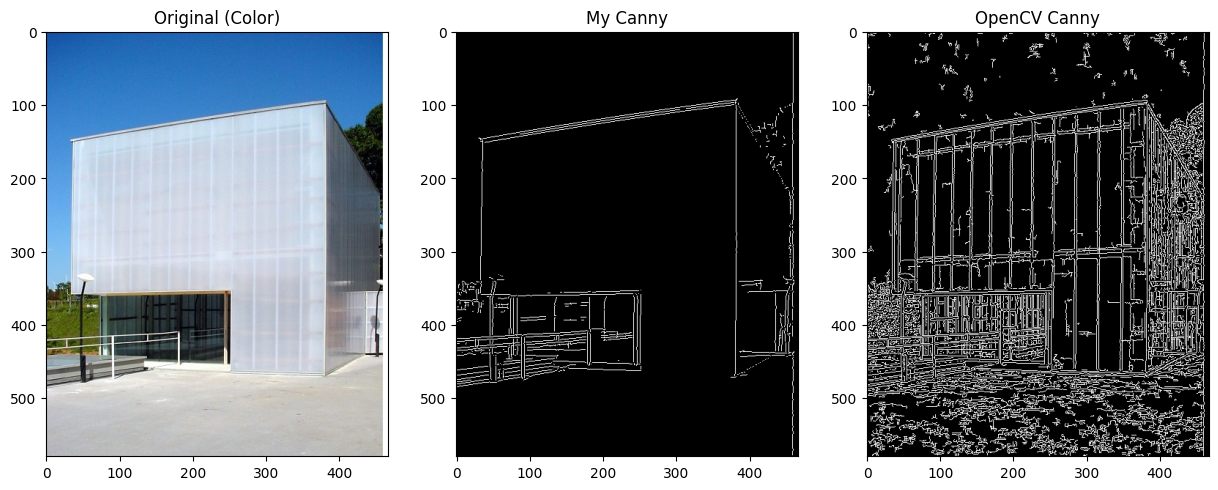


--- Running Part C Experiments ---


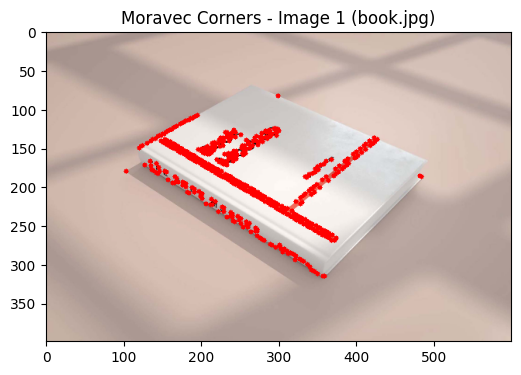

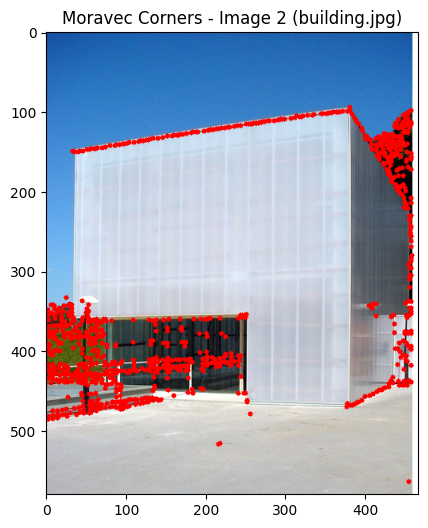

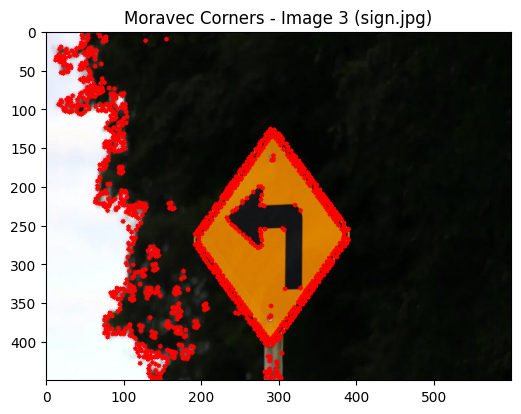

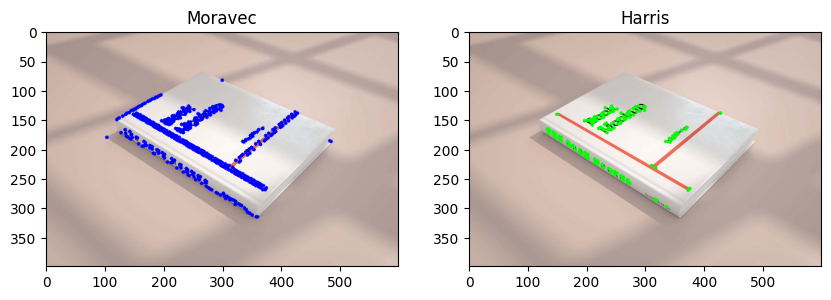

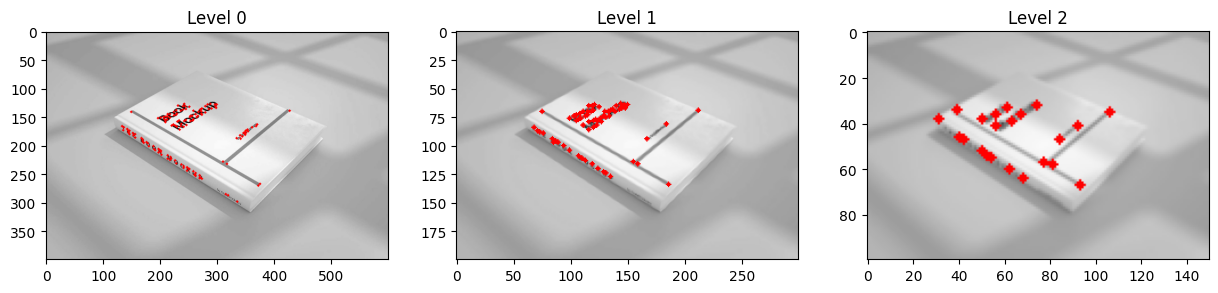


--- Rectifying Document (Automatic Mode) ---

--- Running Part D Rectification on document.jpg ---
Auto-Selecting corners using Harris + Geometric Heuristics (MANUAL BLUR)...
Selected Harris Corners: [(np.int64(27), np.int64(19)), (np.int64(567), np.int64(32)), (np.int64(539), np.int64(714)), (np.int64(90), np.int64(698))]


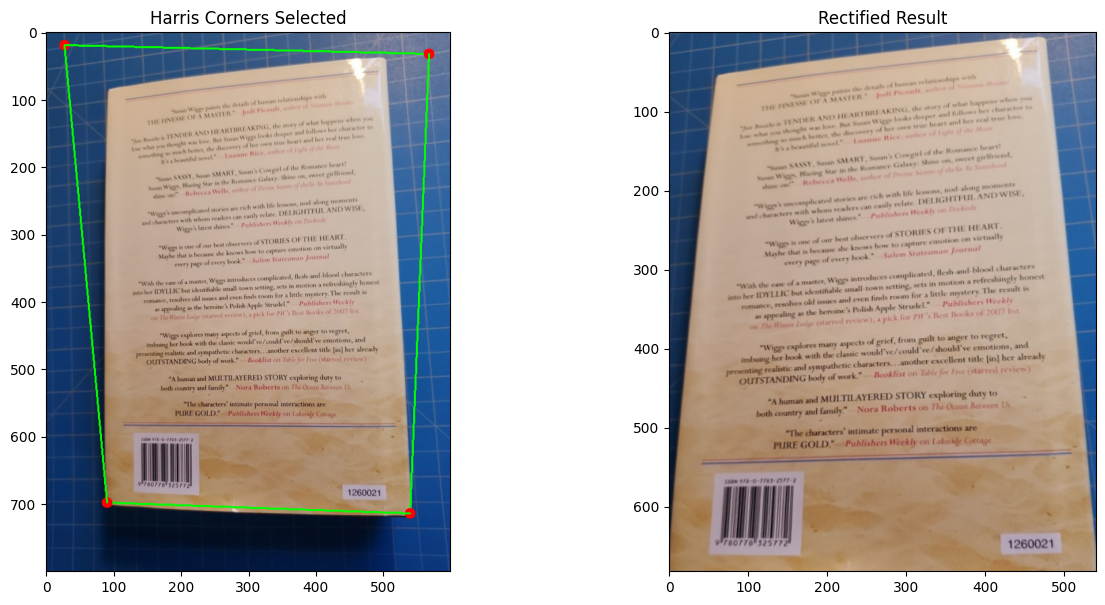


=== EXECUTION COMPLETE ===


In [139]:
if __name__ == "__main__":
    # ==========================================
    # 1. USER CONFIGURATION SECTION
    # ==========================================

    # LIST YOUR UPLOADED IMAGE FILENAMES HERE:
    # (Make sure these match your files exactly!)
    my_images = [
        "book.jpg",          # Img 0: Rectification Target 1
        "building.jpg",      # Img 1: Best for Edges & Corners
        "sign.jpg",          # Img 2: Good for Corners/Rectification
        "bricktexture.jpg",  # Img 3: Best for Noise/Texture
        "document.jpg"       # Img 4: Rectification Target 2
    ]

    # ==========================================
    # 2. AUTOMATED EXECUTION
    # ==========================================

    print("\n=== STARTING COMPUTER VISION PIPELINE ===")

    # --- Run Part A (Noise & Filters) ---
    # We use 'bricktexture.jpg' (Index 3) because texture shows noise best.
    if len(my_images) > 3:
        run_part_a_experiments(my_images[3])
    else:
        run_part_a_experiments(my_images[0])

    # --- Run Part B (Edges) ---
    # We use 'building.jpg' (Index 1) because it has strong structural lines.
    if len(my_images) > 1:
        run_part_b_experiments(my_images[1])
    else:
        run_part_b_experiments(my_images[0])

    # --- Run Part C (Corners) ---
    # Run on first 3 images so that we compare (Building & Sign will look best).
    run_part_c_experiments(my_images[:3])

    # --- Run Part D (Rectification) ---
    # Strategy: Harris + Geometric Heuristic

    # Rectify the Document (if it exists in list)
    print("\n--- Rectifying Document (Automatic Mode) ---")
    run_part_d_experiments(my_images[4], rough_corners=None)

    print("\n=== EXECUTION COMPLETE ===")